# Домашнее задание 4

Это домашнее задание по материалам первых трёх семинаров. Дедлайн по отправке - 02:00 1 марта 2021. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне в Piazza через Private Post.
Файл с Вашим решением должен называться ```Surname_HW#```, где вместо ```Surname``` Вы пишите свою фамилию латиницей, а вместо ```#``` - номер домашнего задания. 
Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 

## Задача 1 (2 pts)

Упражнение 1.3 из [пособия лектора](https://arxiv.org/ftp/arxiv/papers/1711/1711.00394.pdf). Пожалуйста, пишите чёткие обоснования для каждого перехода в доказательстве. Цель этой задачи мотивировать вас разобраться в том, как и почему работает концепция построения нижних оценок сложности методов оптимизации.  

## Задача 2 (5 pts)

Сравните сходимость градиентного спуска, метода сопряжённых градиентов, метода тяжёлого шарика и ускоренного метода Нестерова для задачи

$$
\min_x \log \left( \sum_{i=1}^m \exp(a_i^{\top}x + b_i)\right)
$$

Матрицу $A \in \mathbb{R}^{m \times n}$ и вектор $b$ сгенерируйте случайным образом, рассмотрите различные значения $m$ и $n$ ($m > n$ и $m < n$). 
Какой способ выбора шага для каждого из методов дал наилучшую сходимость? 
Обратите внимание на то, как устойчиво вычислить значения целевой функции. Если вы будете делать это влоб, то промежуточное значение для суммы экспонент может не поместиться в числа типа ```double```

**Решение**

Заметим, что 
$$\log \left( \sum_{i=1}^m e^{v_i}\right) = \log \left( e^m \left( \sum_{i=1}^m e^{v_i-m}\right)\right) = m + \log \left( \sum_{i=1}^m e^{v_i-m}\right) $$

Если взять $m = \max v_i$, то $e^{v_i-m} \leq 1$ и переполнения не возникнет. 

Так и реализуем.


In [1]:

import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

n = 15
m = 50

np.random.seed(42)
d = 100
A = d*(np.random.rand(m, n)-0.5)
b = d*(np.random.rand(m)-0.5)

A = jnp.array(A)
b = jnp.array(b)

@jax.jit
def f(w):
    c = A @ w + b
    m = jnp.max(c)
    return m + jnp.log(jnp.sum(jnp.exp(c-m)))

autograd_f = jax.jit(jax.grad(f))

x0 = jax.random.normal(jax.random.PRNGKey(0), (n,))

In [2]:
def ConjugateGradientFR(f, gradf, x0, num_iter=100, tol=1e-8, callback=None, restart=False):
    x = x0
    grad = gradf(x)
    p = -grad
    it = 0
    while np.linalg.norm(gradf(x)) > tol and it < num_iter:
        alpha = utils.backtracking(x, p, method="Wolfe", beta1=0.1, beta2=0.4, rho=0.5, f=f, grad_f=gradf)
        if alpha < 1e-18:
            break
        x = x + alpha * p
        if callback is not None:
            callback(x)
        grad_next = gradf(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        p = -grad_next + beta * p
        grad = grad_next.copy()
        it += 1
        if restart and it % restart == 0:
            grad = gradf(x)
            p = -grad
    return x

In [3]:
import scipy.optimize as scopt
import liboptpy.restarts as restarts

def callback(x, array):
    array.append(x)

n_restart = 60



In [4]:
import numpy as np
import liboptpy.unconstr_solvers.fo as fo

import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
import liboptpy.base_optimizer as base
import matplotlib.pyplot as plt

In [5]:
class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

In [6]:
beta_test = 0.5
L_trial = 10
methods = {
    "GD Armijo": fo.GradientDescent(f, autograd_f, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.01, init_alpha=1.)),
    r"HB, $\beta = {}$".format(beta_test): HeavyBall(f, autograd_f, ss.ConstantStepSize(1 / L_trial), beta=beta_test),
    "Nesterov": fo.AcceleratedGD(f, autograd_f, ss.ConstantStepSize(1 / L_trial)),
    "Nesterov adaptive": fo.AcceleratedGD(f, autograd_f, ss.Backtracking(rule_type="Lipschitz", rho=0.5, init_alpha=1)),
}
max_iter = 2000
tol = 1e-6

In [7]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)
scopt_cg_array = []
scopt_cg_callback = lambda x: callback(x, scopt_cg_array)
x = scopt.minimize(f, x0, tol=tol, method="CG", jac=autograd_f, callback=scopt_cg_callback, options={"maxiter": max_iter})
x = x.x

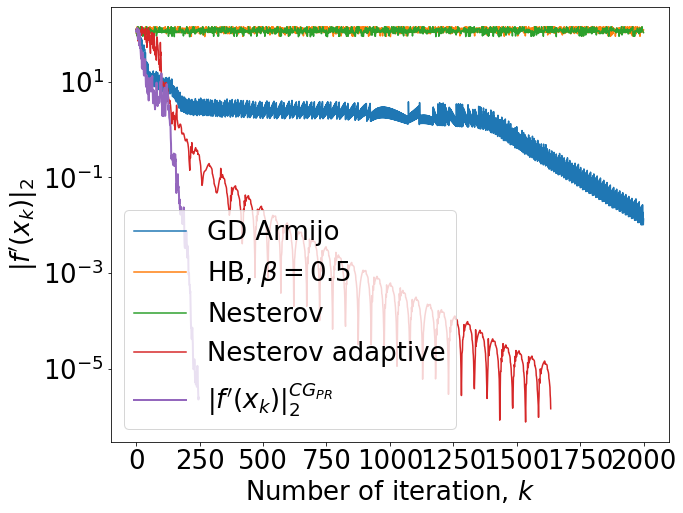

In [37]:
figsize = (10, 8) 
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(autograd_f(x)) for x in methods[m].get_convergence()], label=m)
plt.semilogy([np.linalg.norm(autograd_f(x)) for x in scopt_cg_array], label=r"$\|f'(x_k)\|^{CG_{PR}}_2$", linewidth=2)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)